In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from tqdm import tqdm_notebook
import warnings
from statsmodels.tsa.stattools import kpss
from statsmodels.stats.multitest import multipletests
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
import time
from catboost import CatBoostRegressor, CatBoostClassifier

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import gc

from feature_engineering import reduce_mem_usage, add_rolling_features
from feature_engineering import exponential_smoothing, signal_shifts
from feature_engineering import batch_stats2, add_minus_signal
from feature_engineering import delete_objects_after_rolling
from feature_engineering import add_quantiles, add_target_encoding

from bayes_opt import BayesianOptimization

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
def pred_proc(pred):
    pred = np.round(np.clip(pred, 0, 10))
    return pred.astype(int)

def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

def prepare_df(df, window_sizes, alphas, shifts, batch_sizes):
    df = reduce_mem_usage(df)
    df = add_rolling_features(df, window_sizes)
    df = reduce_mem_usage(df)
    df = exponential_smoothing(df, alphas)
    df = reduce_mem_usage(df)
    df = signal_shifts(df, shifts)
    df = reduce_mem_usage(df)
    df = batch_stats2(df, batch_sizes)
    df = reduce_mem_usage(df)
    df = add_minus_signal(df)
    df = reduce_mem_usage(df)
    
    if 'open_channels' in df.columns:
        y = df['open_channels']
        df = df.drop(columns=['time'])
        return df, y
    else:
        df = df.drop(columns=['time'])
        return df

### 0. Загрузка данных

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(train.shape)
print(test.shape)
print(train.head())

(5000000, 3)
(2000000, 2)
     time  signal  open_channels
0  0.0001 -2.7600              0
1  0.0002 -2.8557              0
2  0.0003 -2.4074              0
3  0.0004 -3.1404              0
4  0.0005 -3.1525              0


### 1. Подготовка датасета

In [3]:
from feature_engineering import reduce_mem_usage, add_rolling_features, exponential_smoothing, signal_shifts

In [4]:
def prepare_df(df, window_sizes, alphas, shifts):
    df = reduce_mem_usage(df)
    df = add_rolling_features(df, window_sizes)
    df = reduce_mem_usage(df)
    df = exponential_smoothing(df, alphas)
    df = reduce_mem_usage(df)
    df = signal_shifts(df, shifts)
    df = reduce_mem_usage(df)
    
    if 'open_channels' in df.columns:
        y = df['open_channels']
        df = df.drop(columns=['time', 'open_channels'])
        return df, y
    else:
        df = df.drop(columns=['time'])
        return df

In [5]:
window_sizes = [5, 100, 5000]
alphas = [0.5, 0.1]
shifts = [1,2,-1,-2]

X_train, y_train = prepare_df(train, window_sizes, alphas, shifts)
X_test = prepare_df(test, window_sizes, alphas, shifts)

Mem. usage decreased to 23.84 Mb (79.2% reduction)



Mem. usage decreased to 286.10 Mb (74.6% reduction)
Mem. usage decreased to 305.18 Mb (15.8% reduction)
Mem. usage decreased to 343.32 Mb (16.3% reduction)
Mem. usage decreased to  7.63 Mb (75.0% reduction)



Mem. usage decreased to 112.53 Mb (74.1% reduction)
Mem. usage decreased to 120.16 Mb (16.0% reduction)
Mem. usage decreased to 135.42 Mb (9.0% reduction)


### 2. Первая наивная попытка: LGBMRegressor

Попробуем обучить LGBMRegressor, разбивая данные на 5 фолдов, обучаясь как в кросс-валидации, при этом для каждого разбиения считать прогноз лучшей итерации на тесте.

In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 64,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.005,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3}

In [5]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [10]:
oof = np.zeros(len(X_train))
prediction = np.zeros(len(X_test))
scores = []

for fold_n, (train_index, valid_index) in tqdm_notebook(enumerate(folds.split(X_train))):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train_, X_valid = X_train[train_index], X_train[valid_index]
    y_train_, y_valid = y_train[train_index], y_train[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 5000, n_jobs = -1)
    model.fit(X_train, y_train, 
            eval_set=[(X_train_, y_train_), (X_valid, y_valid)], eval_metric='mae',
            verbose=500, early_stopping_rounds=200)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Fri Apr 10 11:37:35 2020
Training until validation scores don't improve for 200 rounds
[500]	valid_0's l1: 0.679339	valid_1's l1: 0.67901
[1000]	valid_0's l1: 0.189393	valid_1's l1: 0.1892
[1500]	valid_0's l1: 0.0829863	valid_1's l1: 0.0826718
[2000]	valid_0's l1: 0.0736742	valid_1's l1: 0.0734445
[2500]	valid_0's l1: 0.0718802	valid_1's l1: 0.0716825
[3000]	valid_0's l1: 0.0708139	valid_1's l1: 0.0706402
[3500]	valid_0's l1: 0.0699757	valid_1's l1: 0.0698147
[4000]	valid_0's l1: 0.0693038	valid_1's l1: 0.0691536
[4500]	valid_0's l1: 0.0686871	valid_1's l1: 0.0685456
[5000]	valid_0's l1: 0.0681966	valid_1's l1: 0.0680643
Did not meet early stopping. Best iteration is:
[5000]	valid_0's l1: 0.0681966	valid_1's l1: 0.0680643
Fold 1 started at Fri Apr 10 12:29:40 2020
Training until validation scores don't improve for 200 rounds
[500]	valid_0's l1: 0.679167	valid_1's l1: 0.6797
[1000]	valid_0's l1: 0.189338	valid_1's l1: 0.189421
[1500]	valid_0's l1: 0.0829009	valid_1's l

In [11]:
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})

sample_df['open_channels'] = np.round(prediction).astype(np.int)
sample_df.to_csv("submission.csv", index=False, float_format='%.4f')

**Результат:** 0.71 на public LB

### 3. Возьмем другой датасет

In [3]:
def prepare_df(df, window_sizes, alphas, shifts, batch_sizes):
    df = reduce_mem_usage(df)
    df = add_rolling_features(df, window_sizes)
    df = reduce_mem_usage(df)
    df = exponential_smoothing(df, alphas)
    df = reduce_mem_usage(df)
    df = signal_shifts(df, shifts)
    df = reduce_mem_usage(df)
    df = batch_stats2(df, batch_sizes)
    df = reduce_mem_usage(df)
    df = add_minus_signal(df)
    df = reduce_mem_usage(df)
    
    if 'open_channels' in df.columns:
        y = df['open_channels']
        df = df.drop(columns=['time', 'open_channels'])
        return df, y
    else:
        df = df.drop(columns=['time'])
        return df

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

window_sizes = [5, 100, 1000]
alphas = [0.5, 0.1]
shifts = [1,-1]
batch_sizes = [25000, 2500]


X_train, y_train = prepare_df(train, window_sizes, alphas, shifts, batch_sizes)
X_test = prepare_df(test, window_sizes, alphas, shifts, batch_sizes)

Mem. usage decreased to 23.84 Mb (79.2% reduction)



Mem. usage decreased to 286.10 Mb (74.6% reduction)
Mem. usage decreased to 305.18 Mb (15.8% reduction)
Mem. usage decreased to 324.25 Mb (17.1% reduction)
Mem. usage decreased to 562.67 Mb (51.6% reduction)
Mem. usage decreased to 1096.73 Mb (0.0% reduction)
Mem. usage decreased to  7.63 Mb (75.0% reduction)



Mem. usage decreased to 112.53 Mb (74.1% reduction)
Mem. usage decreased to 120.16 Mb (16.0% reduction)
Mem. usage decreased to 127.79 Mb (9.5% reduction)
Mem. usage decreased to 211.72 Mb (54.3% reduction)
Mem. usage decreased to 413.89 Mb (0.0% reduction)


In [5]:
X_train.head()

,signal,batch,rolling_mean_5,rolling_std_5,rolling_var_5,rolling_min_5,rolling_max_5,rolling_median_5,rolling_min_max_ratio_5,rolling_min_max_diff_5,...,median_batch2500_msignal,max_batch2500_msignal,min_batch2500_msignal,std_batch2500_msignal,mean_abs_chg_batch2500_msignal,abs_max_batch2500_msignal,abs_min_batch2500_msignal,max-min_batch2500_msignal,max/min_batch2500_msignal,abs_avg_batch2500_msignal
0,-2.759766,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.064453,0.856445,-0.707031,3.003906,3.029297,6.226562,4.664062,4.324219,3.308594,5.445312
1,-2.855469,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.160156,0.952148,-0.611328,3.099609,3.125000,6.320312,4.757812,4.417969,3.404297,5.539062
2,-2.408203,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.287109,0.504883,-1.058594,2.652344,2.677734,5.875000,4.312500,3.972656,2.957031,5.093750
3,-3.140625,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.445312,1.237305,-0.326172,3.384766,3.410156,6.609375,5.042969,4.703125,3.689453,5.828125
4,-3.152344,0,-2.863281,0.307617,0.094604,-3.152344,-2.408203,-2.855469,1.308594,0.744141,...,0.457031,1.249023,-0.314453,3.396484,3.421875,6.617188,5.054688,4.714844,3.701172,5.835938


In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

### 4. Макро F1-метрика

Подсчет макро f1, которую будем выводить сразу же при обучении lgbm.

Подсмотрено в этом ноутбуке: https://www.kaggle.com/vbmokin/ion-switching-advanced-fe-lgb-xgb-confmatrix/notebook

In [3]:
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

### 5. Обучение lgbm

Параметры подбираем пока что чисто интуитивно.

In [10]:
num_iterations = 3000
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)
params = {'learning_rate': 0.05, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
          'sample_fraction':0.33}
model = lgb.train(params, lgb.Dataset(X_train_, y_train_),
                  num_iterations,
                  lgb.Dataset(X_valid, y_valid),
                  verbose_eval=100,
                  early_stopping_rounds=200,
                  feval=MacroF1Metric)
model.save_model('model5.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's MacroF1Metric: 0.931818
[200]	valid_0's MacroF1Metric: 0.934456
[300]	valid_0's MacroF1Metric: 0.935061
[400]	valid_0's MacroF1Metric: 0.935205
[500]	valid_0's MacroF1Metric: 0.935294
[600]	valid_0's MacroF1Metric: 0.935436
[700]	valid_0's MacroF1Metric: 0.935445
[800]	valid_0's MacroF1Metric: 0.935532
[900]	valid_0's MacroF1Metric: 0.935671
[1000]	valid_0's MacroF1Metric: 0.935628
[1100]	valid_0's MacroF1Metric: 0.935719
[1200]	valid_0's MacroF1Metric: 0.935687
[1300]	valid_0's MacroF1Metric: 0.935751
[1400]	valid_0's MacroF1Metric: 0.935708
Early stopping, best iteration is:
[1287]	valid_0's MacroF1Metric: 0.935771


132

In [12]:
num_iterations = 2000
model = lgb.train(params, lgb.Dataset(X_train, y_train),
                  num_iterations,
                  verbose_eval=100,
                  feval=MacroF1Metric)

In [14]:
%%time

y_lgb_pred = model.predict(X_test)

Wall time: 1min 6s


In [15]:
def pred_proc(pred):
    pred = np.round(np.clip(pred, 0, 10))
    return pred.astype(int)

In [16]:
y_lgb_pred = pred_proc(y_lgb_pred)

In [24]:
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})

sample_df['open_channels'] = y_lgb_pred
sample_df.to_csv("model5.csv", index=False, float_format='%.4f')

**Результат:** 0.932 на public lb

### 6. LGBM с бОльшим кол-вом фичей

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

window_sizes = [5, 100, 1000, 5000]
alphas = [0.5, 0.2, 0.05]
shifts = [1,-1,2,-2]
batch_sizes = [50000, 25000, 2500]


X_train, y_train = prepare_df(train, window_sizes, alphas, shifts, batch_sizes)
X_test = prepare_df(test, window_sizes, alphas, shifts, batch_sizes)

# X_train = np.array(X_train)
y_train = np.array(y_train)
# X_test = np.array(X_test)

Mem. usage decreased to 23.84 Mb (79.2% reduction)



Mem. usage decreased to 371.93 Mb (74.7% reduction)
Mem. usage decreased to 400.54 Mb (17.6% reduction)
Mem. usage decreased to 438.69 Mb (13.2% reduction)
Mem. usage decreased to 782.01 Mb (53.9% reduction)
Mem. usage decreased to 1535.42 Mb (0.0% reduction)
Mem. usage decreased to  7.63 Mb (75.0% reduction)



Mem. usage decreased to 146.87 Mb (74.3% reduction)
Mem. usage decreased to 158.31 Mb (17.8% reduction)
Mem. usage decreased to 173.57 Mb (7.1% reduction)
Mem. usage decreased to 299.45 Mb (55.8% reduction)
Mem. usage decreased to 589.37 Mb (0.0% reduction)


In [28]:
%%time

num_iterations = 3000
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)
params = {'learning_rate': 0.05, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
          'sample_fraction':0.33}
model = lgb.train(params, lgb.Dataset(X_train_, y_train_),
                  num_iterations,
                  lgb.Dataset(X_valid, y_valid),
                  verbose_eval=100,
                  early_stopping_rounds=200,
                  feval=MacroF1Metric)
model.save_model('model6.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's MacroF1Metric: 0.933017
[200]	valid_0's MacroF1Metric: 0.935251
[300]	valid_0's MacroF1Metric: 0.935518
[400]	valid_0's MacroF1Metric: 0.935647
[500]	valid_0's MacroF1Metric: 0.935838
[600]	valid_0's MacroF1Metric: 0.93596
[700]	valid_0's MacroF1Metric: 0.936037
[800]	valid_0's MacroF1Metric: 0.936087
[900]	valid_0's MacroF1Metric: 0.936211
[1000]	valid_0's MacroF1Metric: 0.936281
[1100]	valid_0's MacroF1Metric: 0.936396
[1200]	valid_0's MacroF1Metric: 0.936453
[1300]	valid_0's MacroF1Metric: 0.936567
[1400]	valid_0's MacroF1Metric: 0.936519
[1500]	valid_0's MacroF1Metric: 0.936491
Early stopping, best iteration is:
[1369]	valid_0's MacroF1Metric: 0.936582
Wall time: 40min 54s


In [29]:
%%time

num_iterations = 2000
model = lgb.train(params, lgb.Dataset(X_train, y_train),
                  num_iterations,
                  verbose_eval=100,
                  feval=MacroF1Metric)

y_lgb_pred = model.predict(X_test)

Wall time: 21min 15s


In [30]:
%%time
y_lgb_pred = pred_proc(y_lgb_pred)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = y_lgb_pred
sample_df.to_csv("model6.csv", index=False, float_format='%.4f')

Wall time: 4.39 s


**Результат:** 0.936 на public LB

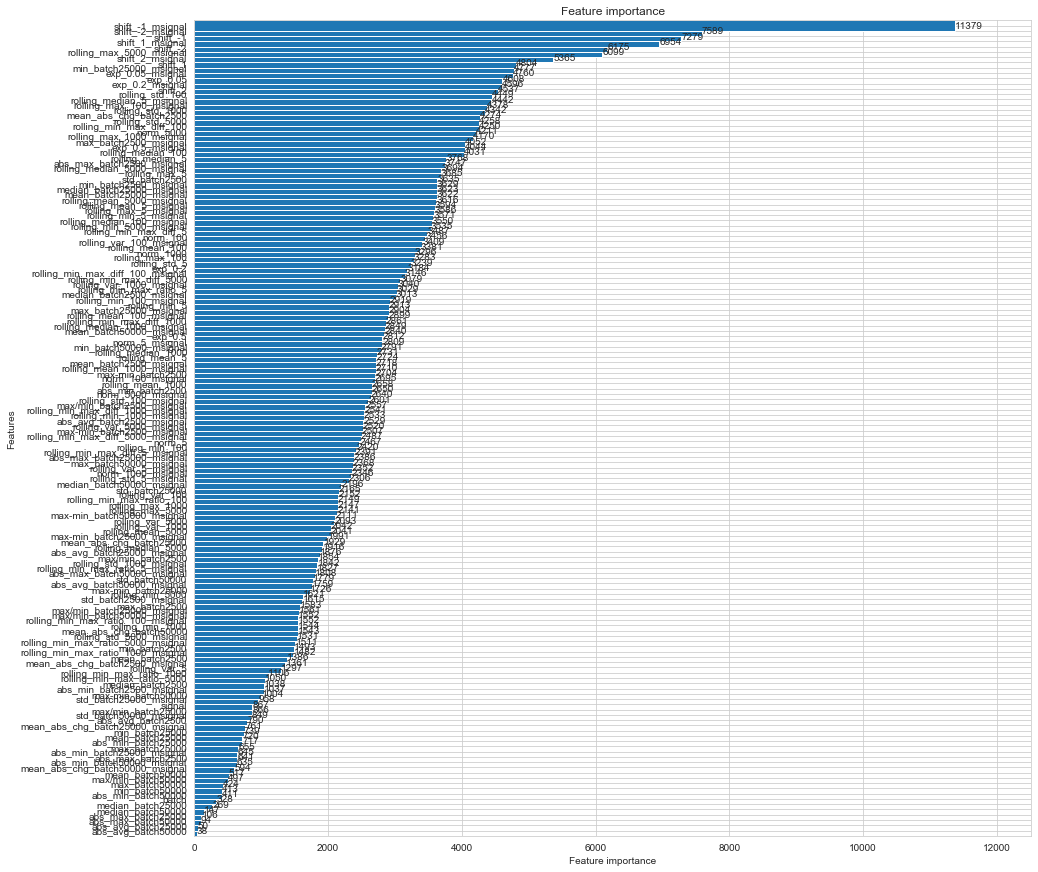

In [33]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(model,ax = axes,height = 2.)
plt.show()

Как видим, здорово себя показывают эксп. сглаживания, сдвиги и роллинги. Сделаем упор на них в следующей модели.

### 7. Еще больше фичей

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

window_sizes = [5, 100, 1000, 5000, 10000]
alphas = [0.5, 0.2, 0.05, 0.7]
shifts = [1,-1,2,-2,3,-3]
batch_sizes = [50000, 25000, 2500]


X_train, y_train = prepare_df(train, window_sizes, alphas, shifts, batch_sizes)
X_test = prepare_df(test, window_sizes, alphas, shifts, batch_sizes)

# X_train = np.array(X_train)
y_train = np.array(y_train)
# X_test = np.array(X_test)

Mem. usage decreased to 23.84 Mb (79.2% reduction)



Mem. usage decreased to 457.76 Mb (74.7% reduction)
Mem. usage decreased to 495.91 Mb (18.7% reduction)
Mem. usage decreased to 553.13 Mb (10.8% reduction)
Mem. usage decreased to 896.45 Mb (50.5% reduction)
Mem. usage decreased to 1764.30 Mb (0.0% reduction)
Mem. usage decreased to  7.63 Mb (75.0% reduction)



Mem. usage decreased to 181.20 Mb (74.5% reduction)
Mem. usage decreased to 196.46 Mb (18.9% reduction)
Mem. usage decreased to 219.35 Mb (5.7% reduction)
Mem. usage decreased to 345.23 Mb (52.2% reduction)
Mem. usage decreased to 680.92 Mb (0.0% reduction)


In [15]:
X_train = delete_objects_after_rolling(X_train, 10000)
add_quantiles(X_train, X_test, n_bins=7)

In [16]:
tmp = []
for i, y in enumerate(y_train):
    if i % 500000 < 10000:
        continue
    else:
        tmp.append(y)

In [17]:
y_train = np.array(tmp)

In [18]:
%%time

num_iterations = 3000
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)
params = {'learning_rate': 0.05, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
          'sample_fraction':0.33}
model = lgb.train(params, lgb.Dataset(X_train_, y_train_),
                  num_iterations,
                  lgb.Dataset(X_valid, y_valid),
                  verbose_eval=100,
                  early_stopping_rounds=200,
                  feval=MacroF1Metric)
model.save_model('model7.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's MacroF1Metric: 0.93366
[200]	valid_0's MacroF1Metric: 0.935862
[300]	valid_0's MacroF1Metric: 0.936162
[400]	valid_0's MacroF1Metric: 0.936317
[500]	valid_0's MacroF1Metric: 0.936515
[600]	valid_0's MacroF1Metric: 0.936509
[700]	valid_0's MacroF1Metric: 0.936523
[800]	valid_0's MacroF1Metric: 0.936641
[900]	valid_0's MacroF1Metric: 0.936617
[1000]	valid_0's MacroF1Metric: 0.936656
[1100]	valid_0's MacroF1Metric: 0.936691
[1200]	valid_0's MacroF1Metric: 0.936778
[1300]	valid_0's MacroF1Metric: 0.936782
[1400]	valid_0's MacroF1Metric: 0.936859
[1500]	valid_0's MacroF1Metric: 0.936927
[1600]	valid_0's MacroF1Metric: 0.936938
[1700]	valid_0's MacroF1Metric: 0.936913
[1800]	valid_0's MacroF1Metric: 0.936934
[1900]	valid_0's MacroF1Metric: 0.936877
[2000]	valid_0's MacroF1Metric: 0.936855
Early stopping, best iteration is:
[1841]	valid_0's MacroF1Metric: 0.936951
Wall time: 2h 30min 13s


In [19]:
%%time

num_iterations = 2000
model = lgb.train(params, lgb.Dataset(X_train, y_train),
                  num_iterations,
                  verbose_eval=100,
                  feval=MacroF1Metric)

y_lgb_pred = model.predict(X_test)

Wall time: 24min 10s


In [23]:
%%time
y_lgb_pred = pred_proc(y_lgb_pred)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = y_lgb_pred
sample_df.to_csv("model7.csv", index=False, float_format='%.4f')

Wall time: 4.2 s


**Результат:** 0.935 на public LB.

### 9. Обучим такой же lgbm, но на данных без дрифта

Датасет без дрифта взят отсюда: https://www.kaggle.com/c/liverpool-ion-switching/discussion/135480

In [3]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')

window_sizes = [5, 100, 1000, 5000]
alphas = [0.5, 0.2, 0.05]
shifts = [1,-1,2,-2]
batch_sizes = [50000, 25000, 2500]


X_train, y_train = prepare_df(train, window_sizes, alphas, shifts, batch_sizes)
X_test = prepare_df(test, window_sizes, alphas, shifts, batch_sizes)

# X_train = np.array(X_train)
y_train = np.array(y_train)
# X_test = np.array(X_test)

# X_train = delete_objects_after_rolling(X_train, 10000)
# add_quantiles(X_train, X_test, n_bins=7)

Mem. usage decreased to 23.84 Mb (79.2% reduction)


KeyboardInterrupt: 

In [8]:
%%time

num_iterations = 3000
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)
params = {'learning_rate': 0.05, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
          'sample_fraction':0.33}
model = lgb.train(params, lgb.Dataset(X_train_, y_train_),
                  num_iterations,
                  lgb.Dataset(X_valid, y_valid),
                  verbose_eval=100,
                  early_stopping_rounds=200,
                  feval=MacroF1Metric)
model.save_model('model9.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's MacroF1Metric: 0.937193
[200]	valid_0's MacroF1Metric: 0.937541
[300]	valid_0's MacroF1Metric: 0.937565
[400]	valid_0's MacroF1Metric: 0.937608
[500]	valid_0's MacroF1Metric: 0.93763
[600]	valid_0's MacroF1Metric: 0.937583
[700]	valid_0's MacroF1Metric: 0.937556
Early stopping, best iteration is:
[514]	valid_0's MacroF1Metric: 0.937659
Wall time: 23min 19s


In [10]:
%%time

num_iterations = 600
model = lgb.train(params, lgb.Dataset(X_train, y_train),
                  num_iterations)

y_lgb_pred = model.predict(X_test)

Wall time: 8min 18s


In [11]:
y_lgb_pred = pred_proc(y_lgb_pred)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = y_lgb_pred
sample_df.to_csv("model9.csv", index=False, float_format='%.4f')

**Результат:** 0.939 на public lb

### 10. Добавим фичи с таргет енкодингом

In [33]:
train = pd.read_csv('data/train_clean.csv')
test = pd.read_csv('data/test_clean.csv')

window_sizes = [5, 100, 1000, 5000]
alphas = [0.5, 0.2, 0.05]
shifts = [1,-1,2,-2]
batch_sizes = [50000, 25000, 2500]


X_train, y_train = prepare_df(train, window_sizes, alphas, shifts, batch_sizes)
X_test = prepare_df(test, window_sizes, alphas, shifts, batch_sizes)

y_train = np.array(y_train)

add_quantiles(X_train, X_test, [3, 7, 15])
add_target_encoding(X_train, X_test, [3, 7, 15])

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

X_train = X_train.drop(columns=['open_channels'])

gc.collect()

Mem. usage decreased to 23.84 Mb (79.2% reduction)



Mem. usage decreased to 381.47 Mb (74.0% reduction)
Mem. usage decreased to 410.08 Mb (17.3% reduction)
Mem. usage decreased to 448.23 Mb (13.0% reduction)
Mem. usage decreased to 762.94 Mb (55.3% reduction)
Mem. usage decreased to 1497.27 Mb (0.0% reduction)
Mem. usage decreased to  7.63 Mb (75.0% reduction)



Mem. usage decreased to 154.50 Mb (73.0% reduction)
Mem. usage decreased to 165.94 Mb (17.1% reduction)
Mem. usage decreased to 181.20 Mb (6.9% reduction)
Mem. usage decreased to 307.08 Mb (55.2% reduction)
Mem. usage decreased to 604.63 Mb (0.0% reduction)



Mem. usage decreased to 1587.87 Mb (15.9% reduction)
Mem. usage decreased to 640.87 Mb (15.8% reduction)


6

In [4]:
%%time
gc.collect()
num_iterations = 3000
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)
params = {'learning_rate': 0.05, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
          'sample_fraction':0.33}

del X_train, y_train

train_set = lgb.Dataset(X_train_, y_train_)
val_set = lgb.Dataset(X_valid, y_valid)

del X_train_, X_valid, y_train_, y_valid

gc.collect()

model = lgb.train(params, train_set,
                  num_iterations,
                  val_set,
                  verbose_eval=100,
                  early_stopping_rounds=200,
                  feval=MacroF1Metric)
model.save_model('model10.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's MacroF1Metric: 0.937142
[200]	valid_0's MacroF1Metric: 0.937563
[300]	valid_0's MacroF1Metric: 0.937675
[400]	valid_0's MacroF1Metric: 0.937667
[500]	valid_0's MacroF1Metric: 0.93772
[600]	valid_0's MacroF1Metric: 0.937751
[700]	valid_0's MacroF1Metric: 0.937672
[800]	valid_0's MacroF1Metric: 0.937705
Early stopping, best iteration is:
[609]	valid_0's MacroF1Metric: 0.937757
Wall time: 20min 12s


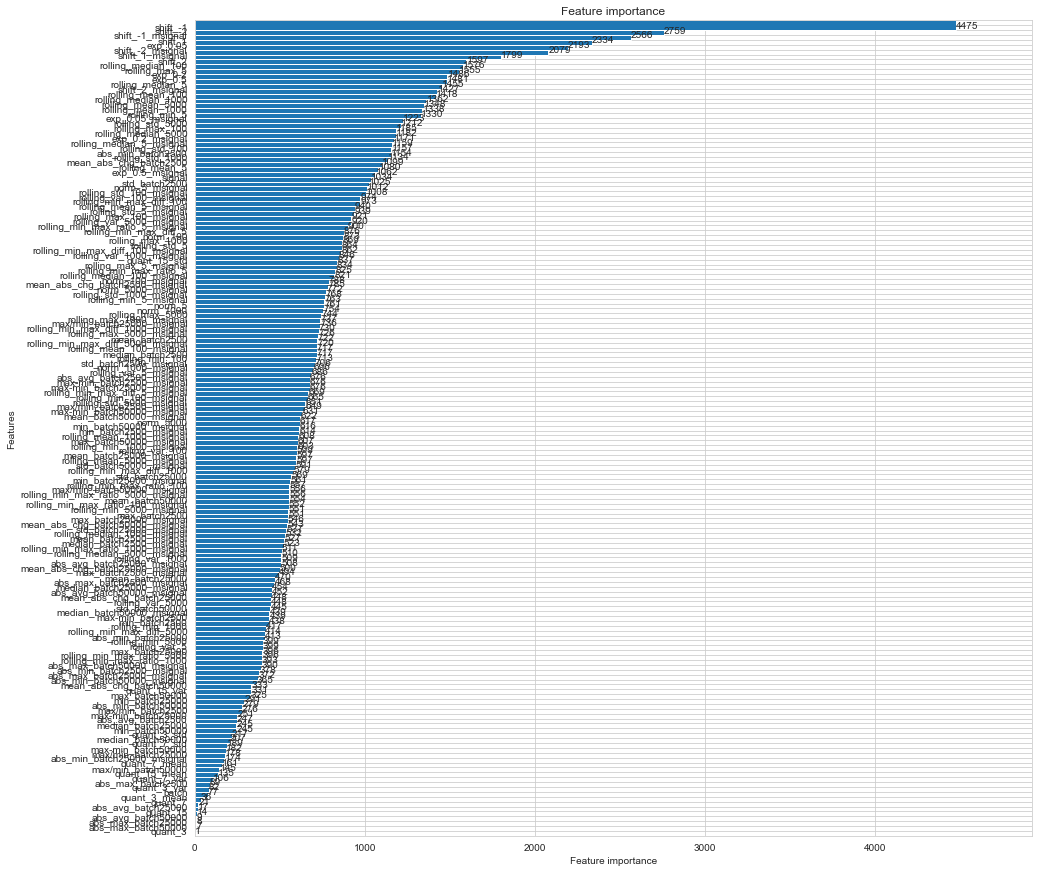

In [5]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(model,ax = axes,height = 2.)
plt.show()

In [6]:
del train_set, val_set
gc.collect()

40

In [10]:
%%time

train_set = lgb.Dataset(X_train, y_train)

del X_train, y_train

gc.collect()

num_iterations = 600
model = lgb.train(params, train_set,
                  num_iterations)

y_lgb_pred = model.predict(X_test)

np.save('model10_test_preds.npy', y_lgb_pred)

Wall time: 8min 14s


In [11]:
y_lgb_pred = pred_proc(y_lgb_pred)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = y_lgb_pred
sample_df.to_csv("model10.csv", index=False, float_format='%.4f')

**Результат:** 0.939 на public lb

### 11. cv-loop

In [36]:
def lgb_cv_loop(X_train, y_train, X_test):
    n_fold = 5
    folds = KFold(n_splits=n_fold, shuffle=True, random_state=17)
    
    num_iterations = 900
    
    oof = np.zeros(len(X_train))
    prediction = np.zeros(len(X_test))
    scores = []
    
    for training_index, validation_index in tqdm_notebook(folds.split(X_train), total=n_fold):
        gc.collect()
        
        # разбиение на трэйн и валидацию
        X_train_ = X_train.iloc[training_index]
        y_train_ = y_train[training_index]
        X_valid = X_train.iloc[validation_index]
        y_valid = y_train[validation_index]
        
        train_set = lgb.Dataset(X_train_, y_train_)
        
        del X_train_, y_train_
        
        gc.collect()
        
        # обучение модели
        model = lgb.train(params, train_set, num_iterations)
        
        # скор на валидации
        preds = model.predict(X_valid)
        oof[validation_index] = preds.reshape(-1,)
        preds = np.round(np.clip(preds, 0, 10)).astype(int)
        score = f1_score(y_valid, preds, average = 'macro')
        scores.append(score)
        
        # предсказание на тесте
        preds = model.predict(X_test)
        prediction += preds
        
        print(f'score: {score}')
        
    prediction /= n_fold
    prediction = np.round(np.clip(prediction, 0, 10)).astype(int)
    
    return scores, oof, prediction

In [22]:
params = {'learning_rate': 0.05, 
          'max_depth': -1, 
          'num_leaves': 200,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
          'sample_fraction':0.33}

In [23]:
%%time
scores, oof, prediction = lgb_cv_loop(X_train, y_train, X_test)

score: 0.9377723991122747
score: 0.9377418056780993
score: 0.9374989672286218
score: 0.9393080850181423
score: 0.9385557886223648

Wall time: 34min 57s


In [24]:
np.mean(scores)

0.9381754091319007

In [25]:
np.save('model10_oof_preds.npy', oof)

### 12. Bayesian optimization

In [16]:
def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed=101):
    dtrain = lgb.Dataset(data=X, label=y)

    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction,
                 max_depth, min_split_gain, min_child_weight, num_iterations):
        
        params = {'application': 'regression',
                  'learning_rate': 0.05,
                  'early_stopping_round': 100,
                  'metric': 'MacroF1Metric',
                  'n_jobs': -1}
                  #параметры для gpu (убрать при использовании cpu)
                  #'device': 'gpu',
                  #'gpu_platform_id': 0,
                  #'gpu_device_id': 0}
        
        params["num_iterations"] = int(round(num_iterations))
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_results = lgb.cv(params, dtrain, nfold=5, seed=seed,
                            categorical_feature=[], stratified=False,
                            verbose_eval=None, feval=MacroF1Metric)
        
        return np.max(cv_results['MacroF1Metric-mean'])
    
    pds = {'num_leaves': (80, 220),
           'feature_fraction': (0.1, 0.9),
           'bagging_fraction': (0.8, 1),
           'max_depth': (15, 30),
           'min_split_gain': (0.001, 0.1),
           'min_child_weight': (10, 25),
           'num_iterations': (100, 1000)
          }

    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
    optimizer.maximize(init_points=init_iter, n_iter=n_iters)
    
    return optimizer

In [17]:
def lgbm_train(dtrain, best_params, num_iterations=200):
    
    params = {'application': 'regression', 'num_iterations': num_iterations,
                    'learning_rate': 0.05,
                    'metric': 'MacroF1Metric',
                    'n_jobs': -1}
        
    params["num_leaves"] = int(round(best_params['num_leaves']))
    params['feature_fraction'] = max(min(best_params['feature_fraction'], 1), 0)
    params['bagging_fraction'] = max(min(best_params['bagging_fraction'], 1), 0)
    params['max_depth'] = int(round(best_params['max_depth']))
    params['min_split_gain'] = best_params['min_split_gain']
    params['min_child_weight'] = best_params['min_child_weight']
    
    model = lgb.train(params, dtrain, 200, verbose_eval=100,
                      feval=MacroF1Metric)
    
    return model

In [18]:
op = bayesion_opt_lgbm(X_train, y_train, init_iter=5, n_iters=20,
                  random_state=17, seed = 17)

|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_sp... | num_it... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9381   |  0.8589   |  0.5245   |  17.87    |  11.02    |  0.07891  |  690.7    |  169.3    |
|  2        |  0.9383   |  0.9151   |  0.1313   |  20.37    |  24.19    |  0.006944 |  877.6    |  202.8    |
|  3        |  0.9379   |  0.8102   |  0.6219   |  23.28    |  18.96    |  0.04887  |  354.7    |  121.7    |
|  4        |  0.9377   |  0.9123   |  0.4168   |  26.83    |  16.28    |  0.01525  |  235.8    |  87.73    |
|  5        |  0.938    |  0.9436   |  0.3339   |  17.98    |  22.47    |  0.05723  |  174.1    |  156.3    |
|  6        |  0.938    |  0.9638   |  0.13     |  29.77    |  18.75    |  0.05716  |  993.1    |  82.91    |
|  7        |  0.9383   |  0.8483   |  0.4234   |  15.07    |  21.99    |  0.02238  |  873.9    |  201.8    |
|  8      

MemoryError: 

### 13. Модель на результатах bayesian opt

In [32]:
%%time

params = {'learning_rate': 0.02,
          'bagging_fraction': 0.88,
          'feature_fraction': 0.53,
          'min_child_weight': 12.4,
          'min_split_gain': 0.06,
          'max_depth': 27, 
          'num_leaves': 218,
          'metric': 'logloss', 
          'random_state': 17, 
          'n_jobs':-1, 
         #'sample_fraction':0.33
         }

gc.collect()
num_iterations = 3000
X_train_, X_valid, y_train_, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=17)

del X_train, y_train

train_set = lgb.Dataset(X_train_, y_train_)
val_set = lgb.Dataset(X_valid, y_valid)

del X_train_, X_valid, y_train_, y_valid

gc.collect()

model = lgb.train(params, train_set,
                  num_iterations,
                  val_set,
                  verbose_eval=100,
                  early_stopping_rounds=200,
                  feval=MacroF1Metric)
model.save_model('lgb13.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's MacroF1Metric: 0.614335
[200]	valid_0's MacroF1Metric: 0.936323
[300]	valid_0's MacroF1Metric: 0.937467
[400]	valid_0's MacroF1Metric: 0.937577
[500]	valid_0's MacroF1Metric: 0.937678
[600]	valid_0's MacroF1Metric: 0.937667
[700]	valid_0's MacroF1Metric: 0.937722
[800]	valid_0's MacroF1Metric: 0.937742
[900]	valid_0's MacroF1Metric: 0.937774
[1000]	valid_0's MacroF1Metric: 0.937717
Early stopping, best iteration is:
[869]	valid_0's MacroF1Metric: 0.937803
Wall time: 24min 52s


In [37]:
%%time
scores, oof, prediction = lgb_cv_loop(X_train, y_train, X_test)

score: 0.9378635292772155
score: 0.9380152351255461
score: 0.9375839819218609
score: 0.9393842052037662
score: 0.9384854338633025

Wall time: 40min 46s


In [38]:
np.mean(scores)

0.9382664770783382

In [39]:
np.save('lgb13_oof_preds.npy', oof)

In [40]:
%%time

train_set = lgb.Dataset(X_train, y_train)

del X_train, y_train

gc.collect()

num_iterations = 900
model = lgb.train(params, train_set,
                  num_iterations)

y_lgb_pred = model.predict(X_test)

np.save('lgb13_test_preds.npy', y_lgb_pred)

Wall time: 9min 41s


In [41]:
y_lgb_pred = pred_proc(y_lgb_pred)
sample_df = pd.read_csv("data/sample_submission.csv", dtype={'time':str})
sample_df['open_channels'] = y_lgb_pred
sample_df.to_csv("lgb13.csv", index=False, float_format='%.4f')

**Результат:** 0.94 на public lb